In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics spacy
!python -q -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 144.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 259.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 151.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 170.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 115.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 218.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 231.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 184.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 154.2 MB/s eta 0:00:00
     

In [ ]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

import re
import os
import cv2
import copy
import math
import random
import warnings
import collections

import numpy as np
import matplotlib.pyplot as plt

import urllib.request as urllib

from PIL import Image
from google.colab.patches import cv2_imshow

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torchmetrics.text import ROUGEScore

from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    RandomAffine,
    RandomAutocontrast
)

try:
    from torchvision.transforms.v2 import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.datasets.utils import download_and_extract_archive

import spacy
spacy = spacy.load("en_core_web_sm")

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
ANNOTATION_PATH = "experiment/dataset/Flickr8k.token.txt"
IMAGE_PATH = "experiment/dataset/Flicker8k_Dataset"

In [ ]:
METRIC_TO_MONITOR = "val_loss"
METRIC_MODE       = "min"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 651470215


In [ ]:
START_TOKEN = ""
END_TOKEN = ""
PAD_TOKEN = ""
OOV_TOKEN = ""

In [ ]:
MAX_SEQUENCE = 30
IMAGE_SIZE = 300

In [ ]:
TEMPERATURE = 0.1
TOP_P = 0.9

In [ ]:
NUM_HEAD = 32
NUM_KV_HEAD = 8
NUM_LAYER = 1
EMBED_DIM = 640
HEAD_DIM = EMBED_DIM // NUM_HEAD
ROPE_BASE = 10000
MLP_SCALE = 3.5
DROPOUT = math.sin(math.sqrt(math.e * math.pi))
EPS_NORM = 1e-5

In [ ]:
MAX_EPOCH = 36
BATCH_SIZE = 128
LEARNING_RATE = 3.1e-4
REDUCE_LR_FACTOR = 0.69

In [ ]:
MILESTONES = 1. / math.sqrt(MAX_EPOCH) * (
    np.array(
        [m for m in range(1, int(math.sqrt(MAX_EPOCH)))]
    )
)

In [ ]:
DATASET_URL = {
    "image" : (
        "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
        "Flickr8k_Dataset.zip",
    ),
    "text"   : (
        "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
        "Flickr8k_text.zip",
    ),
}

In [ ]:
for dat in DATASET_URL.values():
    url, filename = dat
    download_and_extract_archive(
        url,
        "experiment/dataset",
        filename=filename,
    )
    os.remove(os.path.join("experiment/dataset", filename))

100%|██████████| 1115419746/1115419746 [00:09<00:00, 123731918.41it/s]


Extracting experiment/dataset/Flickr8k_Dataset.zip to experiment/dataset


100%|██████████| 2340801/2340801 [00:00<00:00, 45961767.30it/s]


Extracting experiment/dataset/Flickr8k_text.zip to experiment/dataset


In [ ]:
class ToRGB(object):
    def __call__(self, image):
        assert 'PIL' in str(type(image)), "Expected PIL Image"
        return image.convert("RGB")

In [ ]:
TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

TRANSFORM_AUGMENTATION = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        RandomHorizontalFlip(),
        RandomAutocontrast(p=0.25),
        RandomAffine(
            degrees=22.5,
            scale=(math.sqrt(0.5 * math.pi), math.sqrt(math.pi)),
            shear=5.,
        ),
    ]
)

In [ ]:
class Tokenizer(object):
    def __init__(self, freq_threshold=1):
        self.encoder = collections.defaultdict(lambda : 3)
        self.encoder[END_TOKEN] = 2
        self.encoder[START_TOKEN] = 1
        self.encoder[PAD_TOKEN] = 0

        self.freq_threshold = freq_threshold

        frequencies = dict()
        idx = len(self.encoder)

        with open(ANNOTATION_PATH) as captions:
            sentence_list = [
                line.rstrip("\n").split("\t")[-1].strip().lower()
                for line in captions.readlines()
            ]

        for sentence in sentence_list:
            tokenized_sentence = [
                tok.text.lower() for tok in spacy.tokenizer(sentence.strip())
            ]
            for word in tokenized_sentence:
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    idx += 1
                    self.encoder[word] = idx

        self.decoder = dict()
        self.decoder[0] = PAD_TOKEN
        self.decoder[1] = START_TOKEN
        self.decoder[2] = END_TOKEN
        self.decoder[3] = OOV_TOKEN
        for k, v in self.encoder.items():
            if v not in self.decoder:
                self.decoder[v] = k

    def __len__(self):
        assert len(self.encoder) == len(self.decoder)
        return len(self.encoder)

    def encode(self, text):
        numericalized_token = list()
        del_oov_token = False

        for token in spacy.tokenizer(text.strip()):
            if token.text.lower() not in self.encoder:
                del_oov_token = True

            numericalized_token.append(self.encoder[token.text.lower()])

            if del_oov_token:
                del self.encoder[token.text.lower()]
                del_oov_token = False

        return numericalized_token

    def decode(self, tokens):
        return " ".join([self.decoder[token] for token in tokens])

In [ ]:
Tokenizer = Tokenizer()
print(f"Vocab size: {len(Tokenizer.decoder)}")

Vocab size: 8506


In [ ]:
def tokenize(text):
    sos_token = Tokenizer.encoder[START_TOKEN]
    eos_token = Tokenizer.encoder[END_TOKEN]
    tokens = [sos_token] + Tokenizer.encode(text) + [eos_token]

    result = torch.full(
        (MAX_SEQUENCE,),
        Tokenizer.encoder[PAD_TOKEN],
        dtype=torch.long,
    )

    if len(tokens) > MAX_SEQUENCE:
        tokens = tokens[:MAX_SEQUENCE]
        tokens[-1] = eos_token

    result[:len(tokens)] = torch.tensor(tokens)

    return result.long()

In [ ]:
# class Flickr8KDataset(data.Dataset):
#     def __init__(self, split):
#         assert split in ["train", "val", "test", "inference"]

#         self.images = list()
#         self.captions = list()

#         with open(ANNOTATION_PATH) as caption_file:
#             for line in caption_file.readlines():
#                 # Image name and captions are separated using a tab
#                 img_name, caption = line.rstrip("\n").split("\t")

#                 # Each image is repeated five times for the five different
#                 # captions. Each image name has a suffix `#(caption_number)`
#                 img_name = img_name.split("#")[0]
#                 img_name = os.path.join(IMAGE_PATH, img_name.strip())

#                 caption = caption.strip()

#                 # We will remove caption that are either too short to too long
#                 tokens = [tok.text.lower() for tok in spacy.tokenizer(caption)]

#                 if img_name.endswith("jpg"):
#                     self.images.append(img_name)
#                     self.captions.append(caption)

#         random.seed(SEED)
#         random.shuffle(self.images)

#         random.seed(SEED)
#         random.shuffle(self.captions)

#         n_data = len(self.images)

#         if split == "train":
#             self.transform = TRANSFORM_AUGMENTATION
#             start = 0
#             end = int(0.8 * n_data)
#         else:
#             self.transform = TRANSFORM
#             if split == "val":
#                 start = int(0.8 * n_data)
#                 end = int(0.9 * n_data)
#             else:
#                 start = int(0.9 * n_data)
#                 end = n_data

#         self.images = self.images[start:end]
#         self.captions = self.captions[start:end]

#         self.split = split

#     def raw_image(self, index):
#         assert self.split == "inference"
#         return Image.open(self.images[index]).convert("RGB")

#     def inference_data(self, index):
#         assert self.split == "inference"
#         image = self.transform(Image.open(self.images[index]))
#         return image

#     def __len__(self):
#         assert len(self.images) == len(self.captions)
#         return len(self.images)

#     def __getitem__(self, index):
#         image = self.transform(Image.open(self.images[index]))
#         caption = tokenize(self.captions[index])
#         return image, caption


class Flickr8KDataset(data.Dataset):
    def __init__(self, split):
        assert split in ["train", "val", "test", "inference"]

        self.images = list()
        self.captions = list()

        with open(ANNOTATION_PATH) as caption_file:
            for line in caption_file.readlines():
                # Image name and captions are separated using a tab
                img_name, caption = line.rstrip("\n").split("\t")

                # Each image is repeated five times for the five different
                # captions. Each image name has a suffix `#(caption_number)`
                img_name = img_name.split("#")[0]
                img_name = os.path.join(IMAGE_PATH, img_name.strip())

                caption = caption.strip()

                # We will remove captions that are either too short or too long
                tokens = [tok.text.lower() for tok in spacy.tokenizer(caption)]

                if img_name.endswith("jpg"):
                    self.images.append(img_name)
                    self.captions.append(caption)

        # Limit the number of images and captions to 2000
        # if len(self.images) > 6000:
        #     self.images = self.images[:6000]
        #     self.captions = self.captions[:]

        random.seed(SEED)
        random.shuffle(self.images)

        random.seed(SEED)
        random.shuffle(self.captions)

        n_data = len(self.images)

        if split == "train":
            self.transform = TRANSFORM_AUGMENTATION
            start = 0
            end = int(0.8 * n_data)
        else:
            self.transform = TRANSFORM
            if split == "val":
                start = int(0.8 * n_data)
                end = int(0.9 * n_data)
            else:
                start = int(0.9 * n_data)
                end = n_data

        self.images = self.images[start:end]
        self.captions = self.captions[start:end]

        self.split = split

    def raw_image(self, index):
        assert self.split == "inference"
        return Image.open(self.images[index]).convert("RGB")

    def inference_data(self, index):
        assert self.split == "inference"
        image = self.transform(Image.open(self.images[index]))
        return image

    def __len__(self):
        assert len(self.images) == len(self.captions)
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(Image.open(self.images[index]))
        caption = tokenize(self.captions[index])
        return image, caption


In [ ]:
class CollateFunction(object):
    def __init__(self, pad_idx=Tokenizer.encoder[PAD_TOKEN]):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)

        captions = [item[1] for item in batch] + [torch.randn(MAX_SEQUENCE + 1)]
        captions = pad_sequence(
            captions,
            batch_first=True,
            padding_value=self.pad_idx,
        )[:-1, ...]
        return images, captions.long()

In [ ]:
CollateFunction = CollateFunction()

In [ ]:
TrainDataset = Flickr8KDataset('train')
ValDataset = Flickr8KDataset('val')
TestDataset = Flickr8KDataset('test')

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

In [ ]:
class RMSNorm(nn.Module):
    """
    Implements Root Mean Square Normalization introduced in
    https://arxiv.org/pdf/1910.07467.pdf.

    Reference implementation (used for correctness verfication)
    can be found here:
    https://github.com/facebookresearch/llama/blob/main/llama/model.py

    Args:
        dim (int): embedding size
        eps (float): small value to avoid division by zero. Default: 1e-6
    """

    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.scale

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    """
    This class implements Rotary Positional Embedding (RoPE)
    proposed in https://arxiv.org/abs/2104.09864.

    Reference implementation (used for correctness verfication)
    can be found here:
    https://github.com/facebookresearch/llama/blob/main/llama/model.py#L450

    In this implementation we cache the embedding for each position upto
    ``max_seq_len`` by computing this during init.

    Args:
        dim (int): Embedding dimension. This is usually set to the dim of each
            head in the attention module computed as ````embed_dim`` // ``num_heads````
        max_seq_len (int): Maximum expected sequence length for the
            model, if exceeded the cached freqs will be recomputed
        base (int): The base for the geometric progression used to compute
            the rotation angles
    """

    def __init__(
        self,
        dim,
        max_seq_len=4096,
        base=10_000,
    ):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_seq_len = max_seq_len
        self._rope_init()

    def _rope_init(self):
        theta = 1.0 / (
            self.base
            ** (torch.arange(0, self.dim, 2)[: (self.dim // 2)].float() / self.dim)
        )
        self.register_buffer(
            "theta",
            theta.to("cuda" if torch.cuda.is_available() else "cpu"),
            persistent=False,
        )
        self.build_rope_cache(self.max_seq_len)

    def build_rope_cache(self, max_seq_len = 4096):
        # Create position indexes `[0, 1, ..., max_seq_len - 1]`
        seq_idx = torch.arange(
            max_seq_len, dtype=self.theta.dtype, device=self.theta.device
        )

        # Outer product of theta and position index; output tensor has
        # a shape of [max_seq_len, dim // 2]
        idx_theta = torch.einsum("i, j -> ij", seq_idx, self.theta).float()

        # cache includes both the cos and sin components and so the output shape is
        # [max_seq_len, dim // 2, 2]
        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        self.register_buffer("cache", cache, persistent=False)

    def forward(self, x, input_pos=None):
        """
        Args:
            x (Tensor): input tensor with shape
                [bsz, seq_len, num_heads, head_dim]
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Returns:
            Tensor: output tensor with RoPE applied

        Notation used for tensor shapes:
            - b: batch size
            - s: sequence length
            - n_h: num heads
            - h_d: head dim

        TODO: The implementation below can be made more efficient
        for inference.
        """
        # input tensor has shape [b, s, n_h, n_d]
        seq_len = x.size(1)

        # extract the values based on whether input_pos is set or not. When
        # input_pos is provided, we're in inference mode
        rope_cache = (
            self.cache[:seq_len] if input_pos is None else self.cache[input_pos]
        )

        # reshape input; the last dimension is used for computing the output.
        # Cast to float to match the reference implementation
        # tensor has shape [b, s, n_h, n_d // 2, 2]
        xshaped = x.float().reshape(*x.shape[:-1], -1, 2)

        # reshape the cache for broadcasting
        # tensor has shape [1, s, 1, n_d // 2, 2]
        rope_cache = rope_cache.view(1, xshaped.size(1), 1, xshaped.size(3), 2)

        # tensor has shape [b, s, n_h, n_d // 2, 2]
        x_out = torch.stack(
            [
                xshaped[..., 0] * rope_cache[..., 0]
                - xshaped[..., 1] * rope_cache[..., 1],
                xshaped[..., 1] * rope_cache[..., 0]
                + xshaped[..., 0] * rope_cache[..., 1],
            ],
            -1,
        )

        # tensor has shape [b, s, n_h, n_d]
        x_out = x_out.flatten(3)
        return x_out.type_as(x)

In [ ]:
class KVCache(nn.Module):
    """
    Standalone nn.Module containing a kv-cache to cache past key and values
    during inference.

    Args:
        max_batch_size (int): maximum batch size model will be run with
        max_seq_len (int): maximum sequence length model will be run with
        num_heads (int): number of heads. We take num_heads instead of
            num_kv_heads because the cache is created after we've expanded the
            key and value tensors to have the same shape as the query tensor.
            See CausalAttention for more details
        head_dim (int): per-attention head embedding dimension
        dtype (torch.dtype): dtype for the caches
    """

    def __init__(
        self,
        max_batch_size,
        max_seq_len,
        num_heads,
        head_dim,
        dtype=torch.float32,
    ):
        super().__init__()
        cache_shape = (max_batch_size, num_heads, max_seq_len, head_dim)
        self.register_buffer(
            "k_cache",
            torch.zeros(
                cache_shape,
                dtype=dtype,
                device="cuda" if torch.cuda.is_available() else "cpu"
            ),
            persistent=False,
        )
        self.register_buffer(
            "v_cache",
            torch.zeros(
                cache_shape,
                dtype=dtype,
                device="cuda" if torch.cuda.is_available() else "cpu"
            ),
            persistent=False,
        )
        self.max_batch_size = max_batch_size

    def update(self, input_pos, k_val, v_val):
        # input_pos: [S], k_val: [B, H, S, D]
        assert input_pos.shape[0] == k_val.shape[2]

        k_out = self.k_cache
        v_out = self.v_cache
        k_out[:, :, input_pos] = k_val
        v_out[:, :, input_pos] = v_val

        return k_out, v_out

In [ ]:
class CausalSelfAttention(nn.Module):
    """Multi-headed grouped query self-attention (GQA) layer introduced
    in https://arxiv.org/pdf/2305.13245v1.pdf.

    GQA is a version of multiheaded attention (MHA) which uses fewer
    key/value heads than query heads by grouping n query heads for each
    key and value head. Multi-Query Attention is an extreme
    version where we have a single key and value head shared by all
    query heads.

    Following is an example of MHA, GQA and MQA with num_heads = 4

    (credit for the documentation:
    https://github.com/Lightning-AI/lit-gpt/blob/main/lit_gpt/config.py).


    ::

        ┌───┐┌───┐┌───┐┌───┐     ┌───┐    ┌───┐             ┌───┐
        │ v ││ v ││ v ││ v │     │ v │    │ v │             │ v │
        └───┘└───┘└───┘└───┘     └───┘    └───┘             └───┘
        │    │    │    │         │        │                 │
        ┌───┐┌───┐┌───┐┌───┐     ┌───┐    ┌───┐             ┌───┐
        │ k ││ k ││ k ││ k │     │ k │    │ k │             │ k │
        └───┘└───┘└───┘└───┘     └───┘    └───┘             └───┘
        │    │    │    │      ┌──┴──┐  ┌──┴──┐      ┌────┬──┴─┬────┐
        ┌───┐┌───┐┌───┐┌───┐  ┌───┐┌───┐┌───┐┌───┐  ┌───┐┌───┐┌───┐┌───┐
        │ q ││ q ││ q ││ q │  │ q ││ q ││ q ││ q │  │ q ││ q ││ q ││ q │
        └───┘└───┘└───┘└───┘  └───┘└───┘└───┘└───┘  └───┘└───┘└───┘└───┘
        ◀──────────────────▶  ◀──────────────────▶  ◀──────────────────▶
                MHA                    GQA                   MQA
        n_kv_heads =4          n_kv_heads=2           n_kv_heads=1

    Args:
        embed_dim (int): embedding dimension for the model
        num_heads (int): number of query heads. For MHA this is also the
            number of heads for key and value
        num_kv_heads (int): number of key and value heads. If specified,
            user should ensure `num_heads` % `num_kv_heads` == 0. Default value is
            `None`, in which case this is the same as MHA
        head_dim (int): dimension of each head, calculated by ``embed_dim`` // ``num_heads``.
        q_proj (nn.Module): projection layer for query.
        k_proj (nn.Module): projection layer for key.
        v_proj (nn.Module): projection layer for value.
        output_proj (nn.Module): projection layer for output.
        pos_embeddings (nn.Module): positional embeddings layer, e.g. RotaryPositionalEmbeddings.
        kv_cache (Optional[KVCache]): KVCache object used to cache key and value.
            If not specified, then no caching is used.
        max_seq_len (int): maximum sequence length supported by the model.
            This is needed to compute the RoPE Cache. Default: 4096.
        attn_dropout (float): dropout value passed onto the
            scaled_dot_product_attention function. This argument is ignored if the
            self.training is False. Default value is 0.0.

    Raises:
        ValueError: If `num_heads` % `num_kv_heads` != 0
        ValueError: If `embed_dim` % `num_heads` != 0
        ValueError: If `attn_dropout` < 0 or > 1
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        num_kv_heads,
        head_dim,
        q_proj,
        k_proj,
        v_proj,
        output_proj,
        pos_embeddings,
        kv_cache=None,
        max_seq_len=4096,
        attn_dropout=0.0,
    ):
        super().__init__()
        if num_heads % num_kv_heads != 0:
            raise ValueError(
                f"num_heads ({num_heads}) must be divisible by "
                f"num_kv_heads ({num_kv_heads})"
            )

        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by "
                f"num_heads ({num_heads})"
            )

        if attn_dropout < 0 or attn_dropout > 1:
            raise ValueError(f"attn_dropout ({embed_dim}) must be between 0.0 and 1.0")

        # Set attributes
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.embed_dim = embed_dim
        self.attn_dropout = attn_dropout
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len

        # Set layers
        self.kv_cache = kv_cache
        self.q_proj = q_proj
        self.k_proj = k_proj
        self.v_proj = v_proj
        self.output_proj = output_proj
        self.pos_embeddings = pos_embeddings

    def forward(self, x, y=None, mask=None, input_pos=None):
        """
        Args:
            x (Tensor): input tensor with shape
                [batch_size x seq_length x embed_dim]
            y (Optional[Tensor]): input tensor with shape
                [batch_size x 1 x embed_dim]
            mask (Optional[Tensor]): Optional tensor which contains the mask.
                Only used during inference. Default is None.
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Returns:
            Tensor: output tensor with attention applied

        Raises:
            ValueError: if seq_len of x is bigger than max_seq_len

        Notation used for tensor shapes:
            - b: batch size
            - s: sequence length
            - n_h: num heads
            - n_kv: num kv heads
            - d: embed dim
            - h_d: head dim

        TODO:
            - Return the attention weights
            - Make application of positional embeddings optional
        """
        # input has shape [b, s, d]
        bsz, seq_len, _ = x.shape

        if seq_len > self.max_seq_len:
            raise ValueError(
                f"seq_len ({seq_len}) of input tensor should be smaller "
                f"than max_seq_len ({self.max_seq_len})"
            )

        if y is None:
            y = x

        kv_seq_len = y.shape[1]

        # q has shape [b, s, num_heads * head_dim]
        # k has shape [b, s or 1, num_kv_heads * head_dim]
        # v has shape [b, s or 1, num_kv_heads * head_dim]
        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        # number of queries per key/value
        q_per_kv = self.num_heads // self.num_kv_heads

        # q: [b, s, n_kv, q_per_kv, h_d]
        # k: [b, s or 1, n_kv, 1, h_d]
        # v: [b, s or 1, n_kv, 1, h_d]
        q = q.view(bsz, seq_len, self.num_kv_heads, q_per_kv, self.head_dim)
        k = k.view(bsz, kv_seq_len, self.num_kv_heads, 1, self.head_dim)
        v = v.view(bsz, kv_seq_len, self.num_kv_heads, 1, self.head_dim)

        # if needed, expand the key and value tensors to have the same shape
        # as the query tensor by copying values across the relevant dim
        if self.num_heads != self.num_kv_heads:
            k = k.expand(bsz, kv_seq_len, self.num_kv_heads, q_per_kv, self.head_dim)
            v = v.expand(bsz, kv_seq_len, self.num_kv_heads, q_per_kv, self.head_dim)

        # llama2 applies the RoPE embeddings on tensors with shape
        # [b, s or 1, n_h, h_d]
        # Reshape the tensors before we apply RoPE
        q = q.reshape(bsz, seq_len, -1, self.head_dim)
        k = k.reshape(bsz, kv_seq_len, -1, self.head_dim)
        v = v.reshape(bsz, kv_seq_len, -1, self.head_dim)

        # Apply positional embeddings
        q = self.pos_embeddings(q, input_pos)
        k = self.pos_embeddings(k, input_pos)

        # [b, n_h, s or 1, h_d]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Update key-value cache
        if self.kv_cache is not None:
            k, v = self.kv_cache.update(input_pos, k, v)

        # Flash attention from https://pytorch.org/blog/accelerating-large-language-models/
        output = nn.functional.scaled_dot_product_attention(
            q,
            k,
            v,
            attn_mask=mask,
            dropout_p=self.attn_dropout,
            is_causal=self.kv_cache is None,
        )

        # reshape the output to be the same shape as the input
        output = output.transpose(1, 2).contiguous().view(bsz, seq_len, -1)
        return self.output_proj(output)

In [ ]:
def _get_clones(module, n):
    """
    Return a list of ``n`` identical layers.

    Args:
        module (nn.Module): module to be cloned
        n (int): number of clones

    Returns:
        nn.ModuleList: list of ``n`` identical layers
    """
    # FIXME: copy.deepcopy() is not defined on nn.module
    return nn.ModuleList([copy.deepcopy(module) for i in range(n)])

In [ ]:
class TransformerEncoderLayer(nn.Module):
    """Transformer layer derived from the Llama2 model. Normalization is applied
       before the attention **and** FF layer.

    Args:
        attn (CausalSelfAttention): Attention module.
        mlp (nn.Module): Feed-forward module.
        sa_norm_x (nn.Module): Normalization to be applied before self-attention.
        mlp_norm (nn.Module): Normalization to be applied before the feed-forward layer.
    """

    def __init__(self, attn, mlp, sa_norm, mlp_norm):
        super().__init__()
        self.sa_norm = sa_norm
        self.attn = attn
        self.mlp_norm = mlp_norm
        self.mlp = mlp

    def forward(self, x, mask=None, input_pos=None):
        """
        Args:
            x (Tensor): input tensor with shape
                [batch_size x 1 x embed_dim]
            mask (Optional[Tensor]): Optional tensor which contains the mask.
                Only used during inference. Default is None.
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Returns:
            Tensor: output tensor with same shape as input
                [batch_size x 1 x embed_dim]

        Notation used for tensor shapes:
            - b: batch size
            - d: embed dim

        TODO:
            - Make position of norm configurable
        """
        # Input tensor and attention output have the same shape
        # [b, 1, d]
        # Norm applied before self-attention
        attn_out = self.attn(self.sa_norm(x), mask=mask, input_pos=input_pos)

        # Residual connection; shape: [b, 1, d]
        h = attn_out + x

        # Norm applied before the feedforward layer
        mlp_out = self.mlp(self.mlp_norm(h))

        # Residual connection; shape: [b, 1, d]
        out = h + mlp_out
        return out

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder derived from the Llama2 architecture.

    Args:
        feature_extractor (nn.Module): Image feature extractor.
        layer (TransformerEncoderLayer): Transformer Encoder layer.
        num_layers (int): Number of Transformer Encoder layers.
        max_seq_len (int): maximum sequence length the model will be run with, as used
            by KVCache
        num_heads (int): number of query heads. For MHA this is also the
            number of heads for key and value. This is used to setup the
            KVCache
        head_dim (int): embedding dimension for each head in self-attention. This is used
            to setup the KVCache
        norm (nn.Module): Callable that applies normalization to the output of the encoder.

    Note:
        Arg values are checked for correctness (eg: ``attn_dropout`` belongs to [0,1])
        in the module where they are used. This helps reduces the number of raise
        statements in code and improves readability.
    """

    def __init__(
        self,
        feature_extractor,
        layer,
        num_layers,
        max_seq_len,
        num_heads,
        head_dim,
        norm,
    ):
        super().__init__()

        self.feature_extractor = feature_extractor
        self.layers = _get_clones(layer, num_layers)
        self.norm = norm
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.causal_mask = None

    def setup_caches(self, max_batch_size, dtype=torch.float32):
        # inference only
        for layer in self.layers:
            layer.attn.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )

        # causal_mask is used during inference to ensure we're attending
        # to the right tokens
        self.causal_mask = torch.tril(
            torch.ones(
                self.max_seq_len,
                self.max_seq_len,
                dtype=torch.bool,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
        )

    def clear_caches(self):
        for layer in self.layers:
            layer.attn.kv_cache = None
        self.causal_mask = None

    def forward(self, image, input_pos=None):
        """
        Args:
            image (Tensor): input tensor with shape [b x c x h x w]
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Note: At the very first step of inference, when the model is provided with a prompt,
        ``input_pos`` would contain the positions of all of the tokens in the prompt
        (eg: ``torch.arange(prompt_length)``). This is because we will need to compute the
        KV values for each position.

        Returns:
            Tensor: output tensor with shape [b x 1 x d]

        Raises:
            ValueError: if causal_mask is set but input_pos is None

        Notation used for tensor shapes:
            - b: batch size
            - c: channel
            - h: height
            - w: width
            - v: vocab size
            - d: embed dim
            - m_s: max seq len
        """
        # input tensor of shape [b, c, h, w]
        bsz = image.shape[0]

        # shape: [b, 1, d]
        h = self.feature_extractor(image).view(bsz, 1, -1)

        mask = None
        if self.causal_mask is not None:
            if input_pos is None:
                raise ValueError(
                    "Caches are setup, but the position of input token is missing"
                )
            # shape: [1, input_pos_len, m_s]
            # in most cases input_pos_len should be 1
            mask = self.causal_mask[None, None, input_pos]

        for layer in self.layers:
            # shape: [b, 1, d]
            h = layer(h, mask, input_pos)

        # shape: [b, 1, d]
        return self.norm(h).float()

In [ ]:
class TransformerDecoderLayer(nn.Module):
    """Transformer layer derived from the Llama2 model. Normalization is applied
       before the attention **and** FF layer.

    Args:
        attn1 (CausalSelfAttention): Attention module.
        attn2 (CausalSelfAttention): Attention module.
        mlp (nn.Module): Feed-forward module.
        sa_norm_x1 (nn.Module): Normalization to be applied before self-attention.
        sa_norm_x2 (nn.Module): Normalization to be applied before self-attention.
        mlp_norm (nn.Module): Normalization to be applied before the feed-forward layer.
    """

    def __init__(self, attn1, attn2, mlp, sa_norm_x1, sa_norm_x2, mlp_norm):
        super().__init__()
        self.sa_norm_x1 = sa_norm_x1
        self.sa_norm_x2 = sa_norm_x2
        self.attn1 = attn1
        self.attn2 = attn2
        self.mlp_norm = mlp_norm
        self.mlp = mlp

    def forward(self, x, y, mask=None, input_pos=None):
        """
        Args:
            x (Tensor): input tensor with shape
                [batch_size x seq_length x embed_dim]
            y (Tensor): input tensor with shape
                [batch_size x 1 x embed_dim]
            mask (Optional[Tensor]): Optional tensor which contains the mask.
                Only used during inference. Default is None.
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Returns:
            Tensor: output tensor with same shape as input
                [batch_size x seq_length x embed_dim]

        Notation used for tensor shapes:
            - b: batch size
            - s: sequence length
            - d: embed dim

        TODO:
            - Make position of norm configurable
        """
        # Input tensor and attention output have the same shape
        # [b, s, d]
        # Norm applied before self-attention
        attn_out = self.attn1(self.sa_norm_x1(x), mask=mask, input_pos=input_pos)

        # Residual connection; shape: [b, s, d]
        h = attn_out + x

        # [b, s, d]
        # Norm applied before self-attention
        attn_out = self.attn2(
            self.sa_norm_x2(h),
            y,
            mask=mask,
            input_pos=input_pos,
        )

        # Residual connection; shape: [b, s, d]
        h = attn_out + h

        # Norm applied before the feedforward layer
        mlp_out = self.mlp(self.mlp_norm(h))

        # Residual connection; shape: [b, s, d]
        out = h + mlp_out
        return out

In [ ]:
class TransformerDecoder(nn.Module):
    """
    Transformer Decoder derived from the Llama2 architecture.

    Args:
        tok_embedding (nn.Embedding): PyTorch embedding layer, to be used to move
            tokens to an embedding space.
        layer (TransformerDecoderLayer): Transformer Decoder layer.
        num_layers (int): Number of Transformer Decoder layers.
        max_seq_len (int): maximum sequence length the model will be run with, as used
            by KVCache
        num_heads (int): number of query heads. For MHA this is also the
            number of heads for key and value. This is used to setup the
            KVCache
        head_dim (int): embedding dimension for each head in self-attention. This is used
            to setup the KVCache
        norm (nn.Module): Callable that applies normalization to the output of the decoder,
            before final MLP.
        output (nn.Linear): Callable that applies a linear transformation to the output of
            the decoder.

    Note:
        Arg values are checked for correctness (eg: ``attn_dropout`` belongs to [0,1])
        in the module where they are used. This helps reduces the number of raise
        statements in code and improves readability.
    """

    def __init__(
        self,
        tok_embedding,
        layer,
        num_layers,
        max_seq_len,
        num_heads,
        head_dim,
        norm,
        output,
    ):
        super().__init__()

        self.tok_embedding = tok_embedding
        self.layers = _get_clones(layer, num_layers)
        self.norm = norm
        self.output = output
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.causal_mask = None

    def setup_caches(self, max_batch_size, dtype=torch.float32):
        # inference only
        for layer in self.layers:
            layer.attn1.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )
            layer.attn2.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )

        # causal_mask is used during inference to ensure we're attending
        # to the right tokens
        self.causal_mask = torch.tril(
            torch.ones(
                self.max_seq_len,
                self.max_seq_len,
                dtype=torch.bool,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
        )

    def clear_caches(self):
        for layer in self.layers:
            layer.attn1.kv_cache = None
            layer.attn2.kv_cache = None
        self.causal_mask = None

    def forward(self, tokens, enc, input_pos=None):
        """
        Args:
            tokens (Tensor): input tensor with shape [b x s]
            enc (Tensor): extracted feature maps encoder [b x d]
            input_pos (Optional[Tensor]): Optional tensor which contains the position
                of the current token. This is only used during inference. Default is None

        Note: At the very first step of inference, when the model is provided with a prompt,
        ``input_pos`` would contain the positions of all of the tokens in the prompt
        (eg: ``torch.arange(prompt_length)``). This is because we will need to compute the
        KV values for each position.

        Returns:
            Tensor: output tensor with shape [b x s x v]

        Raises:
            ValueError: if causal_mask is set but input_pos is None

        Notation used for tensor shapes:
            - b: batch size
            - s: sequence length
            - v: vocab size
            - d: embed dim
            - m_s: max seq len
        """
        # input tensor of shape [b, s]
        # bsz, seq_len = tokens.shape
        bsz = tokens.shape[0]

        # shape: [b, s, d]
        h = self.tok_embedding(tokens)

        enc = enc.view(bsz, 1, -1)

        mask = None
        if self.causal_mask is not None:
            if input_pos is None:
                raise ValueError(
                    "Caches are setup, but the position of input token is missing"
                )
            # shape: [1, input_pos_len, m_s]
            # in most cases input_pos_len should be 1
            mask = self.causal_mask[None, None, input_pos]

        for layer in self.layers:
            # shape: [b, s, d]
            h = layer(h, enc, mask, input_pos)

        # shape: [b, s, d]
        h = self.norm(h)

        # shape: [b, s, v]
        output = self.output(h).float()
        return output

In [ ]:
class FeedForward(nn.Module):
    """This class implements the feed-forward network derived from Llama2.

    Args:
        gate_proj (nn.Module): Projection from input dim to hidden dim, fed
            through activation and multiplied by up_proj.
        down_proj (nn.Module): Final projection to output dim.
        up_proj (nn.Module): Projection from input dim to hidden dim, multiplied by
            activation(gate_proj).
        activation (nn.Module): Activation function to use. Default is nn.SiLU().
    """

    def __init__(
        self,
        *,
        gate_proj,
        down_proj,
        up_proj,
        activation=nn.SiLU(),
    ):
        super().__init__()
        self.w1 = gate_proj
        self.w2 = down_proj
        self.w3 = up_proj
        self.activation = activation

    def forward(self, x):
        return self.w2(self.activation(self.w1(x)) * self.w3(x))

In [ ]:
class ImageCaptioning(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = MAX_EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        MLP = FeedForward(
            gate_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
            down_proj=nn.Linear(int(EMBED_DIM * MLP_SCALE), EMBED_DIM, bias=False),
            up_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
        )

        # MobileNetV3 + LLaMA 3
        FEATURE_EXTRACTOR = mobilenet_v3_large(
            weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2
        )
        FEATURE_EXTRACTOR.classifier[2] = nn.Dropout(p=DROPOUT, inplace=True)
        FEATURE_EXTRACTOR.classifier[3] = nn.Linear(
            in_features=1280,
            out_features=EMBED_DIM,
            bias=False,
        )
        SELF_ATTENTION = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=RotaryPositionalEmbedding(
                dim=HEAD_DIM,
                max_seq_len=1,
                base=ROPE_BASE,
            ),
            max_seq_len=1,
            attn_dropout=DROPOUT,
        )
        ENCODER_LAYER = TransformerEncoderLayer(
            attn=SELF_ATTENTION,
            mlp=copy.deepcopy(MLP),
            sa_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )
        self.encoder = TransformerEncoder(
            feature_extractor=FEATURE_EXTRACTOR,
            layer=ENCODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
        )

        # LLaMA 3
        TOKEN_EMBEDDING = nn.Embedding(len(Tokenizer.decoder), EMBED_DIM)
        ROPE = RotaryPositionalEmbedding(
            dim=HEAD_DIM,
            max_seq_len=MAX_SEQUENCE,
            base=ROPE_BASE,
        )
        SELF_ATTENTION_1 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )
        SELF_ATTENTION_2 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )
        DECODER_LAYER = TransformerDecoderLayer(
            attn1=SELF_ATTENTION_1,
            attn2=SELF_ATTENTION_2,
            mlp=copy.deepcopy(MLP),
            sa_norm_x1=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            sa_norm_x2=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )
        OUT_PROJECTION = nn.Linear(EMBED_DIM, len(Tokenizer.decoder), bias=False)
        self.decoder = TransformerDecoder(
            tok_embedding=TOKEN_EMBEDDING,
            layer=DECODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
            output=OUT_PROJECTION,
        )

        self.automatic_optimization = False

        self.train_loss = list()
        self.val_loss = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.test_rogue = ROUGEScore()

        self.sanity_check_counter = 1

    def forward(self, image, caption):
        image_feature = self.encoder(image)
        return self.decoder(caption, image_feature)

    def captionize(self, image, temperature=TEMPERATURE, top_p=TOP_P):
        assert image.shape[0] == 1

        self.encoder.setup_caches(max_batch_size=1)
        encoder_feat = self.encoder(
            image,
            input_pos=torch.tensor([0], device=self.device),
        )
        self.encoder.clear_caches()

        self.decoder.setup_caches(max_batch_size=1)

        pred_token = Tokenizer.encoder[START_TOKEN]
        token = [pred_token] + [Tokenizer.encoder[PAD_TOKEN]] * (MAX_SEQUENCE)
        for index in range(MAX_SEQUENCE):
            caption = torch.LongTensor([pred_token]).unsqueeze(0).to(self.device)

            pred_token = self.decoder(
                caption,
                encoder_feat,
                input_pos=torch.tensor([index], device=self.device),
            )

            if temperature > 0:
                # Apply temperature -> make distribution softer (?)
                pred_token = (pred_token / temperature).softmax(-1)[0]
                # Sampling
                psort, pidx = torch.sort(pred_token, dim= -1, descending=True)
                psum = torch.cumsum(psort, dim=-1)
                psort[psum - psort > top_p] = 0.
                psort.div_(psort.sum(dim=-1, keepdim=True))
                pred_token = torch.multinomial(psort, num_samples=1)
                pred_token = torch.gather(pidx, -1, pred_token).transpose(0, 1)
            else:
                pred_token = pred_token.softmax(-1).argmax(2)

            pred_token = pred_token.item()
            token[index + 1] = pred_token

            if pred_token == Tokenizer.encoder[END_TOKEN]:
                break

        self.decoder.clear_caches()

        return self.postprocess_text(Tokenizer.decode(token))

    def postprocess_text(self, text):
        text = text.replace(START_TOKEN, "")
        text = text.replace(END_TOKEN, "")
        text = text.replace(PAD_TOKEN, "")
        text = re.sub(r'\s([,.!?])', r'\1', text)
        text = '. '.join(map(lambda s: s.strip().capitalize(), text.split('.')))
        return text

    def training_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption = caption[:, 1:].reshape(caption.shape[0] * (caption.shape[-1] - 1))

        loss = F.cross_entropy(pred, caption, ignore_index=Tokenizer.encoder[PAD_TOKEN])

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        torch.nn.utils.clip_grad_norm_(
            self.parameters(),
            math.log2(math.sqrt(math.e * math.tau) * math.pi),
        )
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.train_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption = caption[:, 1:].reshape(caption.shape[0] * (caption.shape[-1] - 1))

        loss = F.cross_entropy(pred, caption, ignore_index=Tokenizer.encoder[PAD_TOKEN])

        if self.sanity_check_counter == 0:
            self.log("val_loss", loss, prog_bar=True)
            self.val_loss_recorder.update(loss.data)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            loss = self.val_loss_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                str_report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
                str_report += f"- Epoch: {self.current_epoch}"
                print(str_report)
            self.val_loss.append(loss)
            self.val_loss_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        image, caption = batch

        N_BATCH = image.shape[0]

        rogue1_fmeasure = list()

        for id in range(N_BATCH):
            pred = self.captionize(image[id].unsqueeze(0))
            target = self.postprocess_text(
                Tokenizer.decode(
                    caption[id].cpu()
                    .detach()
                    .numpy()
                    .tolist()
                )
            )
            rogue1_fmeasure.append(
                self.test_rogue(pred, target)['rouge1_fmeasure']
                .cpu()
                .detach()
                .numpy()
                .tolist()
            )

        rogue1_fmeasure = np.array(rogue1_fmeasure).mean()
        self.log("ROGUE-1 F-measure", rogue1_fmeasure, prog_bar=True, logger=True)

    def on_train_end(self):
        # Loss
        img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(img_file)
        plt.clf()
        img = cv2.imread(img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), self.lr)

        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[int(self.max_epoch * ms) for ms in MILESTONES],
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = ImageCaptioning.__name__
MODEL = ImageCaptioning
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    # f"model/{MODEL_NAME}_best.ckpt",
    '/content/drive/MyDrive/ImageCaptioning_best.ckpt'
)
LAST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    # "model/last.ckpt",
    '/content/drive/MyDrive/ImageCaptioning_best.ckpt'
)

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
        save_last=True,
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

# _train_loop()

In [ ]:
INFERENCE_SAMPLE = 9
MAX_CHAR = 50

In [ ]:
model = MODEL.load_from_checkpoint('/content/drive/MyDrive/ImageCaptioning_best.ckpt')
model.eval()

InferenceDataset = Flickr8KDataset('inference')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 44.9MB/s]


<Figure size 640x480 with 0 Axes>

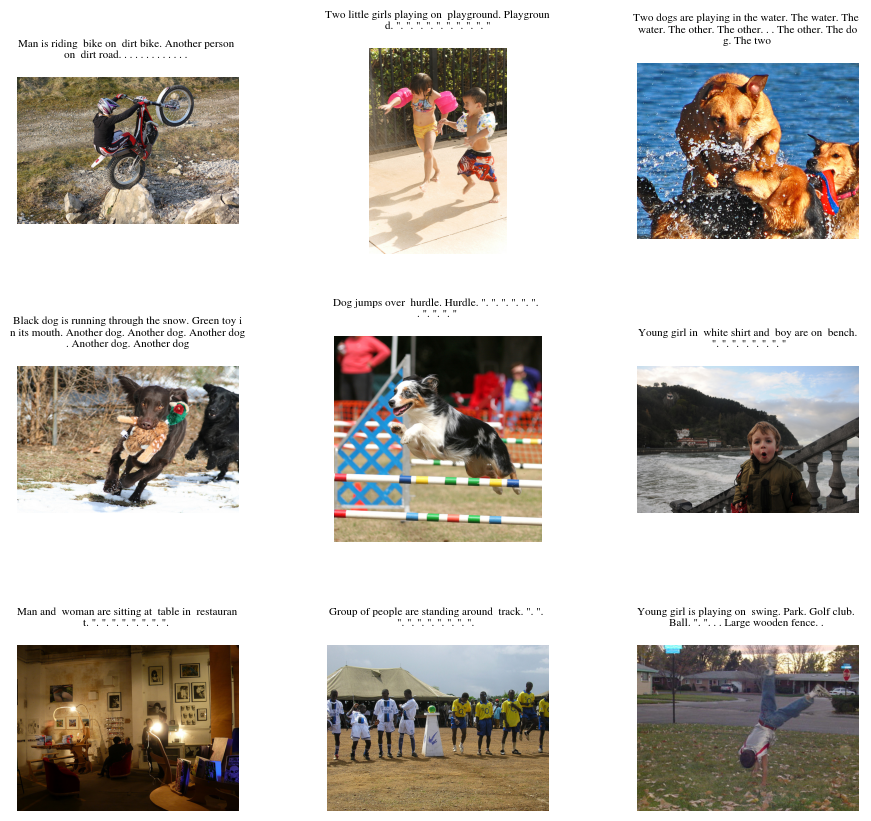

In [ ]:
plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

N_SAMPLE = len(InferenceDataset)
SELECTED_SAMPLE = [
    random.randint(0, N_SAMPLE - 1) for _ in range(INFERENCE_SAMPLE)
]

for index, sample_idx in enumerate(SELECTED_SAMPLE):
    image = InferenceDataset.inference_data(sample_idx)
    image = image.to(
        "cuda" if torch.cuda.is_available() else "cpu"
    ).unsqueeze(0)

    caption = model.captionize(image)
    image = np.array(InferenceDataset.raw_image(sample_idx))

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)

    ax = fig.add_subplot(
        int(math.sqrt(INFERENCE_SAMPLE)),
        int(math.sqrt(INFERENCE_SAMPLE)),
        index + 1,
    )
    ax.imshow(image.copy().astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

In [ ]:
INPUT_URL = "https://static.wikia.nocookie.net/near-pure-good-hero/images/1/12/Yukino.png"  # @param {type:"string"}


def show_result():
    image_raw = cv2.cvtColor(
        cv2.imdecode(
            np.asarray(
                bytearray(urllib.urlopen(INPUT_URL).read()),
                dtype=np.uint8,
            ),
            -1,
        ),
        cv2.COLOR_BGR2RGB,
    )

    image = (
        TRANSFORM(
            Image.fromarray(
                image_raw.copy(),
                "RGB",
            )
        )
        .to("cuda" if torch.cuda.is_available() else "cpu")
        .unsqueeze(0)
    )

    caption = model.captionize(image)

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)
    plt.figure()
    plt.imshow(image_raw.copy())
    plt.title(title)
    plt.axis("off")
    plt.show()

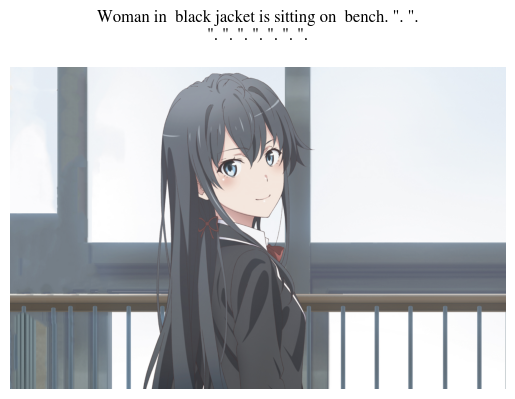

In [ ]:
show_result()

In [ ]:
!pip install flask flask-ngrok

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2024-06-25 18:28:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  17.0MB/s    in 0.8s    

2024-06-25 18:28:31 (17.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
# Run ngrok to tunnel port 5001
get_ipython().system_raw('./ngrok http 5001 &')



In [ ]:
import time
time.sleep(5)  # Allow ngrok to setup the tunnel

# Print the ngrok URL
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
import os
import cv2
import numpy as np
import torch
import urllib
import math
import matplotlib.pyplot as plt
from PIL import Image
from flask import Flask, request, jsonify

# Replace these with your actual imports and model loading code
# from your_model_file import MODEL, Flickr8KDataset, TRANSFORM

app = Flask(__name__)

# Load your model
LAST_MODEL_PATH = '/content/drive/MyDrive/ImageCaptioning_best.ckpt'
model = MODEL.load_from_checkpoint(LAST_MODEL_PATH)
model.eval()

MAX_CHAR = 50

@app.route('/caption', methods=['POST'])
def caption_image():
    print("ENTERED")
    file = request.files['image']
    if not file:
        return jsonify({"error": "No file provided"}), 400

    image_raw = cv2.cvtColor(
        cv2.imdecode(
            np.frombuffer(file.read(), np.uint8),
            cv2.IMREAD_COLOR,
        ),
        cv2.COLOR_BGR2RGB,
    )

    image = (
        TRANSFORM(
            Image.fromarray(
                image_raw.copy(),
                "RGB",
            )
        )
        .to("cuda" if torch.cuda.is_available() else "cpu")
        .unsqueeze(0)
    )

    caption = model.captionize(image)

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)

    plt.figure()
    plt.imshow(image_raw.copy())
    plt.title(title)
    plt.axis("off")
    plt.savefig('result.png')

    return jsonify({"caption": caption})


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://172.28.0.12:5001
INFO:werkzeug:Press CTRL+C to quit
